In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from featuretools.tests.testing_utils import make_ecommerce_entityset
import featuretools as ft
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.linear_model import LogisticRegression
warnings.simplefilter(action='ignore', category=FutureWarning)

SEED = 123

In [2]:
taobao_df = pd.read_csv('taobao_sampled.csv')

In [3]:
taobao_df.shape

(2502944, 21)

In [4]:
#Split dates into days for categorical encoding/create dummies
    #- Double check of outliers in prices
    #- Create dummies for shopping level 
    #- Create dummies for occupation
    #- Create dummies for new_user_class level
    #- figure out encoding function for high cardinality features

<Axes: >

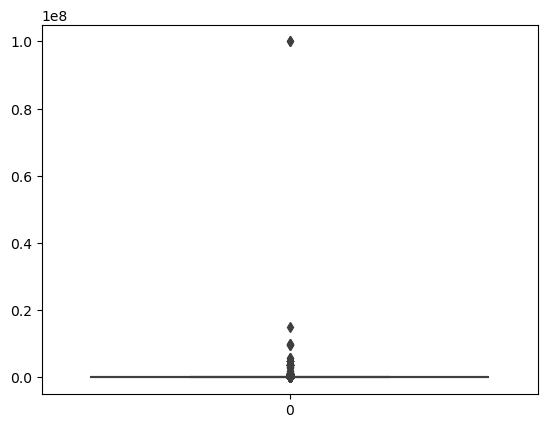

In [5]:
sns.boxplot(taobao_df['price'])

Checking to see the outliers for the price feature, looks like one purchase is way out there

In [6]:
taobao_df['price'].describe().apply(lambda x: format(x, 'f'))

count     2502944.000000
mean          666.351812
std         92261.835265
min             0.010000
25%            87.000000
50%           168.000000
75%           328.000000
max      99999999.000000
Name: price, dtype: object

In [7]:
#Performing the calculations needed to determine the percentiles needed for the box plot to remove the outliers

In [8]:
percentile25 = taobao_df['price'].quantile(0.05)
percentile75 = taobao_df['price'].quantile(0.95)
iqr = percentile75 - percentile25

upper_limit = percentile25 + 1.5 * iqr
lower_limit = percentile75 - 1.5 * iqr

print(f"upper limit: {upper_limit}")
print(f"upper limit: {lower_limit}")

upper limit: 1997.3999999999999
upper limit: -640.1999999999998


In [9]:
#Removed the outliars outside the upper and lower bounds

In [10]:
taobao_df = taobao_df[(taobao_df['price'] >= lower_limit) & (taobao_df['price'] <= upper_limit)]

<Axes: >

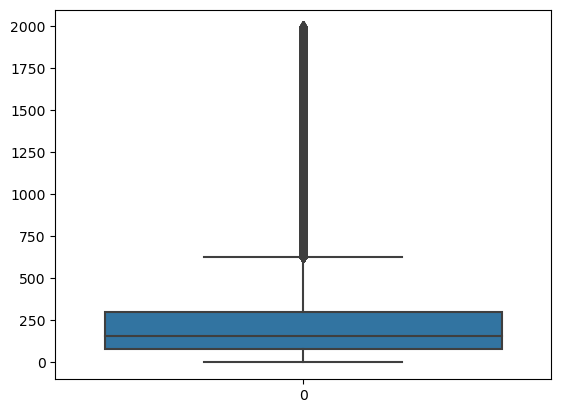

In [11]:
sns.boxplot(taobao_df['price'])

In [12]:
taobao_df.shape

(2415375, 21)

We removed the most signicant outliars based on the price column, originally I thought about doing the default 25/75 quantiles as the values when doing the iqr calculation; however, I thought about how its probably not uncommon for people to spend a lot of money during a sale. I decided to set the maximum price to be around $2000, the majority of the users will spend less than this. About 90,000 entries was dropped because they were outliers. 

In [13]:
taobao_df['price'].describe().apply(lambda x: format(x, 'f'))

count    2415375.000000
mean         249.618795
std          285.377162
min            0.010000
25%           80.000000
50%          159.000000
75%          299.000000
max         1997.000000
Name: price, dtype: object

In [14]:
taobao_df.head()

,Unnamed: 0.1,Unnamed: 0,adgroup_id,cate_id,campaign_id,advertiser_id,brand_id,price,user_id,time_stamp,...,clk,cms_segid,cms_group_id,gender,age_level,shopping_level,occupation,new_user_class_level,date_time,date
0,9542470,9542470,515801,6142,67627,148475,22251.0,198.0,587355,1494008253,...,0,81,10,1,4,3,0,3.0,2017-05-05 18:17:33,05-05-2017
1,11968553,11968553,555608,4520,99167,85336,257191.0,109.0,719615,1494002653,...,0,45,5,2,5,3,0,4.0,2017-05-05 16:44:13,05-05-2017
2,18258616,18258616,567324,4505,108753,55483,353787.0,149.0,193209,1494001709,...,0,0,3,2,3,3,0,3.0,2017-05-05 16:28:29,05-05-2017
3,11909497,11909497,540890,6421,371461,43028,227726.0,329.0,801356,1494026096,...,0,0,4,2,4,3,0,2.0,2017-05-05 23:14:56,05-05-2017
4,13833842,13833842,366682,6735,243675,188705,353787.0,168.0,1070566,1494001286,...,0,0,5,2,5,1,0,2.0,2017-05-05 16:21:26,05-05-2017


Creating a new column to store the time and day of the 'date_time' column, since the month and year doesnt change we dont need a seperate column for them

In [15]:
taobao_df['time'] = pd.to_datetime(taobao_df['date_time']).dt.time
taobao_df['day'] = pd.to_datetime(taobao_df['date_time']).dt.day

In [16]:
taobao_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'adgroup_id', 'cate_id', 'campaign_id',
       'advertiser_id', 'brand_id', 'price', 'user_id', 'time_stamp', 'pid',
       'clk', 'cms_segid', 'cms_group_id', 'gender', 'age_level',
       'shopping_level', 'occupation', 'new_user_class_level', 'date_time',
       'date', 'time', 'day'],
      dtype='object')

In [17]:
#Deleting date_time column along with the index columns since we dont need them anymore

In [18]:
taobao_df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'date_time'], axis=1, inplace=True)

In [19]:
taobao_df.head()

,adgroup_id,cate_id,campaign_id,advertiser_id,brand_id,price,user_id,time_stamp,pid,clk,cms_segid,cms_group_id,gender,age_level,shopping_level,occupation,new_user_class_level,date,time,day
0,515801,6142,67627,148475,22251.0,198.0,587355,1494008253,430539_1007,0,81,10,1,4,3,0,3.0,05-05-2017,18:17:33,5
1,555608,4520,99167,85336,257191.0,109.0,719615,1494002653,430548_1007,0,45,5,2,5,3,0,4.0,05-05-2017,16:44:13,5
2,567324,4505,108753,55483,353787.0,149.0,193209,1494001709,430548_1007,0,0,3,2,3,3,0,3.0,05-05-2017,16:28:29,5
3,540890,6421,371461,43028,227726.0,329.0,801356,1494026096,430539_1007,0,0,4,2,4,3,0,2.0,05-05-2017,23:14:56,5
4,366682,6735,243675,188705,353787.0,168.0,1070566,1494001286,430548_1007,0,0,5,2,5,1,0,2.0,05-05-2017,16:21:26,5


In [20]:
taobao_df['new_user_class_level'] = taobao_df['new_user_class_level'].astype(int)
taobao_df['brand_id'] = taobao_df['brand_id'].astype(int)

In [21]:
taobao_df['new_user_class_level'].dtype

dtype('int32')

In [22]:
#Create dummies for shopping level
#Create dummies for shopping level 
#Create dummies for occupation
#Create dummies for new_user_class level

In [23]:
cols_to_dummy = ['shopping_level', 'occupation' , 'age_level', 'new_user_class_level', 'gender', 'day']
prefix = cols_to_dummy[:]

taobao_df = pd.get_dummies(taobao_df, prefix=prefix, prefix_sep='_', columns=cols_to_dummy, drop_first=True)

In [24]:
# logit = LogisticRegression(random_state=SEED)
# y=taobao_df['clk']
# train = taobao_df[['adgroup_id', 'cate_id', 'campaign_id', 'advertiser_id', 'brand_id', 'user_id', 'pid']]
# columns = [i for i in X_train.columns]

# X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=SEED)

In [25]:
# targ_enc = TargetEncoder(cols=columns, smoothing=8, min_samples_leaf=5).fit(X_train, y_train)
# X_train_te = targ_enc.transform(X_train.reset_index(drop=True))
# X_val_te = targ_enc.transform(X_val.reset_index(drop=True))

In [26]:
# X_train_te.head()

In [27]:
# X_train_te.shape

In [28]:
# X_val_te.head()

In [29]:
# X_val_te.shape

In [30]:
# def get_score(model, X, y, X_val, y_val):
#     model.fit(X, y)
#     y_pred = model.predict_proba(X_val)[:,1]
#     score = roc_auc_score(y_val, y_pred)
#     return score

In [31]:
# te_logit_score = get_score(logit, X_train_te, y_train, X_val_te, y_val)
# print('Logistic Regression score with target encoding:', te_logit_score)

In [32]:
taobao_df.dtypes

adgroup_id                  int64
cate_id                     int64
campaign_id                 int64
advertiser_id               int64
brand_id                    int32
price                     float64
user_id                     int64
time_stamp                  int64
pid                        object
clk                         int64
cms_segid                   int64
cms_group_id                int64
date                       object
time                       object
shopping_level_2            uint8
shopping_level_3            uint8
occupation_1                uint8
age_level_1                 uint8
age_level_2                 uint8
age_level_3                 uint8
age_level_4                 uint8
age_level_5                 uint8
age_level_6                 uint8
new_user_class_level_2      uint8
new_user_class_level_3      uint8
new_user_class_level_4      uint8
gender_2                    uint8
day_6                       uint8
day_7                       uint8
day_8         

In [33]:
categories = ['adgroup_id', 'cate_id', 'campaign_id', 'advertiser_id','brand_id','user_id','pid','cms_segid','cms_group_id','time']

In [34]:
#Converting all the columns in the list above from int to strings, since ints cannot be used for encoding

In [35]:
for i in categories:
    taobao_df[i] = taobao_df[i].map(str)

In [36]:
taobao_df.dtypes

adgroup_id                 object
cate_id                    object
campaign_id                object
advertiser_id              object
brand_id                   object
price                     float64
user_id                    object
time_stamp                  int64
pid                        object
clk                         int64
cms_segid                  object
cms_group_id               object
date                       object
time                       object
shopping_level_2            uint8
shopping_level_3            uint8
occupation_1                uint8
age_level_1                 uint8
age_level_2                 uint8
age_level_3                 uint8
age_level_4                 uint8
age_level_5                 uint8
age_level_6                 uint8
new_user_class_level_2      uint8
new_user_class_level_3      uint8
new_user_class_level_4      uint8
gender_2                    uint8
day_6                       uint8
day_7                       uint8
day_8         

In [37]:
encoder = TargetEncoder()
for i in categories:
    taobao_df[i+'_encoded'] = encoder.fit_transform(taobao_df[i], taobao_df['clk'])

In [38]:
taobao_df.head()

,adgroup_id,cate_id,campaign_id,advertiser_id,brand_id,price,user_id,time_stamp,pid,clk,...,adgroup_id_encoded,cate_id_encoded,campaign_id_encoded,advertiser_id_encoded,brand_id_encoded,user_id_encoded,pid_encoded,cms_segid_encoded,cms_group_id_encoded,time_encoded
0,515801,6142,67627,148475,22251,198.0,587355,1494008253,430539_1007,0,...,0.043029,0.037250,0.043029,0.034556,0.034556,0.041486,0.053756,0.047323,0.048721,0.041486
1,555608,4520,99167,85336,257191,109.0,719615,1494002653,430548_1007,0,...,0.087015,0.046025,0.087015,0.081011,0.081011,0.063045,0.050440,0.053233,0.053980,0.087354
2,567324,4505,108753,55483,353787,149.0,193209,1494001709,430548_1007,0,...,0.042282,0.033789,0.042282,0.021459,0.054848,0.038801,0.050440,0.051986,0.052564,0.018325
3,540890,6421,371461,43028,227726,329.0,801356,1494026096,430539_1007,0,...,0.049388,0.047194,0.048199,0.069149,0.069892,0.057361,0.053756,0.051986,0.050779,0.053445
4,366682,6735,243675,188705,353787,168.0,1070566,1494001286,430548_1007,0,...,0.009434,0.062837,0.009434,0.025138,0.054848,0.041486,0.050440,0.051986,0.053980,0.052151


In [39]:
taobao_df.drop(columns=categories, axis=1, inplace=True)
taobao_df.drop(columns=['time_stamp', 'date'], axis=1, inplace=True)

In [40]:
taobao_df.head()

,price,clk,shopping_level_2,shopping_level_3,occupation_1,age_level_1,age_level_2,age_level_3,age_level_4,age_level_5,...,adgroup_id_encoded,cate_id_encoded,campaign_id_encoded,advertiser_id_encoded,brand_id_encoded,user_id_encoded,pid_encoded,cms_segid_encoded,cms_group_id_encoded,time_encoded
0,198.0,0,0,1,0,0,0,0,1,0,...,0.043029,0.037250,0.043029,0.034556,0.034556,0.041486,0.053756,0.047323,0.048721,0.041486
1,109.0,0,0,1,0,0,0,0,0,1,...,0.087015,0.046025,0.087015,0.081011,0.081011,0.063045,0.050440,0.053233,0.053980,0.087354
2,149.0,0,0,1,0,0,0,1,0,0,...,0.042282,0.033789,0.042282,0.021459,0.054848,0.038801,0.050440,0.051986,0.052564,0.018325
3,329.0,0,0,1,0,0,0,0,1,0,...,0.049388,0.047194,0.048199,0.069149,0.069892,0.057361,0.053756,0.051986,0.050779,0.053445
4,168.0,0,0,0,0,0,0,0,0,1,...,0.009434,0.062837,0.009434,0.025138,0.054848,0.041486,0.050440,0.051986,0.053980,0.052151


In [41]:
taobao_df.head()

,price,clk,shopping_level_2,shopping_level_3,occupation_1,age_level_1,age_level_2,age_level_3,age_level_4,age_level_5,...,adgroup_id_encoded,cate_id_encoded,campaign_id_encoded,advertiser_id_encoded,brand_id_encoded,user_id_encoded,pid_encoded,cms_segid_encoded,cms_group_id_encoded,time_encoded
0,198.0,0,0,1,0,0,0,0,1,0,...,0.043029,0.037250,0.043029,0.034556,0.034556,0.041486,0.053756,0.047323,0.048721,0.041486
1,109.0,0,0,1,0,0,0,0,0,1,...,0.087015,0.046025,0.087015,0.081011,0.081011,0.063045,0.050440,0.053233,0.053980,0.087354
2,149.0,0,0,1,0,0,0,1,0,0,...,0.042282,0.033789,0.042282,0.021459,0.054848,0.038801,0.050440,0.051986,0.052564,0.018325
3,329.0,0,0,1,0,0,0,0,1,0,...,0.049388,0.047194,0.048199,0.069149,0.069892,0.057361,0.053756,0.051986,0.050779,0.053445
4,168.0,0,0,0,0,0,0,0,0,1,...,0.009434,0.062837,0.009434,0.025138,0.054848,0.041486,0.050440,0.051986,0.053980,0.052151


In [42]:
taobao_df.dtypes

price                     float64
clk                         int64
shopping_level_2            uint8
shopping_level_3            uint8
occupation_1                uint8
age_level_1                 uint8
age_level_2                 uint8
age_level_3                 uint8
age_level_4                 uint8
age_level_5                 uint8
age_level_6                 uint8
new_user_class_level_2      uint8
new_user_class_level_3      uint8
new_user_class_level_4      uint8
gender_2                    uint8
day_6                       uint8
day_7                       uint8
day_8                       uint8
day_9                       uint8
day_10                      uint8
day_11                      uint8
day_12                      uint8
day_13                      uint8
adgroup_id_encoded        float64
cate_id_encoded           float64
campaign_id_encoded       float64
advertiser_id_encoded     float64
brand_id_encoded          float64
user_id_encoded           float64
pid_encoded   

In [50]:
from sklearn.model_selection import train_test_split

In [52]:
X = taobao_df.drop(['clk'], axis=1)
y = taobao_df['clk']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(taobao_df)

array([[-0.18087925, -0.23353175, -0.34069636, ..., -1.68018857,
        -1.14976676, -0.3511069 ],
       [-0.49274729, -0.23353175, -0.34069636, ...,  0.57988115,
         0.86884465,  1.21314854],
       [-0.35258188, -0.23353175, -0.34069636, ...,  0.10287853,
         0.32528617, -1.14097136],
       ...,
       [-0.69984169, -0.23353175, -0.34069636, ...,  0.10287853,
         0.5857934 , -1.35767688],
       [-0.46121007, -0.23353175, -0.34069636, ..., -2.31248795,
        -2.41107039, -1.64399345],
       [ 0.31320384, -0.23353175,  2.93516494, ...,  0.10287853,
         0.86884465, -0.19801102]])